# Project Overview

The dataset chosen for this project is the Santander competiton datset. The intention of this project is to demonstrate how to structure a data science pipeline to access remote processing power, in this case an instance on AWS. This is not necessarily required to enable this project to be effectively completed.

Project aims:

    -Submit a competition entry on Kaggle
    -Demonstrate appropriate application of classification techniques
    -Demonstrate use of virtual processing power

# Environment Setup

### Part 1: Creating a virtual environment for the project locally

To contain this project a seperate virtual environment will be setup, the purpose of this environment is to enable development of code which will be then pushed to AWS for running models. The code is displayed here for reference however is executed in Anaconda Prompt.

conda create -n mod3_env python=3.7 anaconda

**Specific packages required not contained within Anaconda**

    pip install Kaggle
    Conda install py-xgboost 

**Kaggle setup**

To use the Kaggle API to access the data set first the Kaggle package must be setup with the appropriate credentials and API key. Details of how to do this are located at: https://github.com/Kaggle/kaggle-api This will become important when using AWS and directly accessing the dataset.

### Part 2: Setting up an AWS instance

Please see blog link above for detailed instructions on how to setup an appropriate instance.

#### Commands to be run in AWS

As for local development a specific virtual environment will be created on the AWS instance. The instance will be Linux with miniconda installed to minimise unnecessary packages. 

conda create -n mod3_env python=3.7

conda activate mod3_env

**Specific packages to install** 

    pip install Kaggle 
    conda install pandas 
    conda install numpy 
    conda install scikit-learn 
    conda install py-xgboost 

### Part 3: Notebook Setup

Testing and development of the various components to be run on the AWS instance will be completed in this Jupyter Notebook. Here the relevant packages will be imported.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import gc

from scipy.stats.mstats import normaltest
from sklearn.model_selection import train_test_split, GridSearchCV 
from sklearn.preprocessing import StandardScaler, QuantileTransformer
from sklearn.metrics import roc_curve, auc
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.metrics import confusion_matrix

import itertools
from imblearn.over_sampling import SMOTE
import xgboost as xgb
import time



# Obtain

The data set is provided by Kaggle, as detailed above the Kaggle API will be used to directly download the data set into the local directory. The 

In [ ]:
import json

with open('kaggle.json') as f:
    kaggle_key = json.load(f)

print(kaggle_key)

In [ ]:
from kaggle.api.kaggle_api_extended import KaggleApi

api = KaggleApi(kaggle_key)
api.authenticate()
files = api.competition_download_files("santander-customer-transaction-prediction")

### Packaged for deployment

The following will be saved as import.py and then run on the AWS instance to import the data.

In [ ]:
import json
from kaggle.api.kaggle_api_extended import KaggleApi

with open('kaggle.json') as f:
    kaggle_key = json.load(f)

print(kaggle_key)



api = KaggleApi(kaggle_key)
api.authenticate()
files = api.competition_download_files("santander-customer-transaction-prediction")

The structure of this project will be to take a random sample (10%) of the dataset to enable development of the various components to  scrub, explore, model and interpret. Theses components will then be run with the full dataset on the AWS instance.

In [2]:
df = pd.read_csv('train.csv.zip', index_col = 'ID_code')

As can be identified of the 202 variables 2 are not predictors, the target and the ID_code. These will be seperated and assigned as the index respectively

In [3]:
df.head()

,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
ID_code,,,,,,,,,,,,,,,,,,,,,
train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,-4.9200,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,3.1468,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,-4.9193,...,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
train_3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,-5.8609,...,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
train_4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,6.2654,...,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 200000 entries, train_0 to train_199999
Columns: 201 entries, target to var_199
dtypes: float64(200), int64(1)
memory usage: 308.2+ MB


As the file has a large memory usage, 308+ MB only a 10% sample will be used in generating the modules for use.

To get the random 10% of the data set the sklearn train test split will be used. This however is not creating a train test split, only selecting a portion  of the data. The train test split will be conducted later.

In [5]:
X, unused_X, y, unused_y = train_test_split(df.drop('target',axis=1), df.target, random_state=100, test_size=0.9) 

This sample is now exported for testing the AWS environment

In [ ]:
df_sample = X.join(pd.DataFrame(y))

In [ ]:
df_sample.to_csv('sample.csv')

Now the original dataframe will be deleted from memory to provide space for later computation and speed up the running of the notebook.

In [ ]:
to_delete = [unused_X, unused_y, df, df_sample]
del to_delete
gc.collect()

In [6]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20000 entries, train_47169 to train_38408
Columns: 200 entries, var_0 to var_199
dtypes: float64(200)
memory usage: 30.7+ MB


Now checking the size of the df at only 30MB it is far more usable

# Scrub

## Pass 1

The following checks will be made of the dataset to confirm the quality of the data, with 200 predictor variables it is important to as far as possible automate these checks, this will also ensure that when running these check on the AWS instance a clear decision can be made on the quality of the data.

In [7]:
X.head()

,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
ID_code,,,,,,,,,,,,,,,,,,,,,
train_47169,12.5222,0.9528,8.0756,8.2170,10.0582,-2.1742,6.3128,15.5889,6.5716,5.9571,...,9.2025,5.9316,3.0285,5.9117,23.2794,-2.3842,14.1623,9.3543,14.2417,-5.0458
train_155550,14.0709,-6.1488,8.3043,8.9169,10.2091,-19.6673,4.8147,17.1123,-4.9200,7.3672,...,-0.6122,9.8561,2.1240,4.2462,19.7968,-1.4454,1.1993,9.9167,21.7781,-2.0514
train_172332,9.8112,-4.1240,12.0592,4.9941,11.9665,-3.8638,6.2426,21.3797,3.5428,8.4973,...,-1.8741,10.9349,1.5351,4.9576,21.5483,0.2687,-3.3322,9.4847,19.4212,3.5930
train_20920,4.5494,2.2167,7.5873,6.8244,13.1144,-8.7595,5.8142,15.2427,6.0176,8.0102,...,-0.2522,8.8744,4.7148,-0.4325,20.7683,-0.2299,1.9904,9.3550,16.7495,-14.8567
train_131887,17.9327,-0.2589,10.8622,8.2798,9.9303,7.5476,5.1549,19.3465,2.6657,7.0753,...,4.9618,6.0059,0.4061,2.7377,13.7905,0.9213,3.9935,8.1599,21.2181,15.4626


In [8]:
X.describe()

,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
count,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,...,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000
mean,10.693275,-1.630333,10.667976,6.791266,11.070288,-5.080342,5.407961,16.510039,0.286783,7.549414,...,3.272966,7.441508,1.924728,3.288719,17.960045,-0.141579,2.335230,8.903571,15.875691,-3.324285
std,3.039247,4.032578,2.642513,2.046214,1.626334,7.857570,0.872402,3.425589,3.339244,1.226859,...,4.604865,3.018890,1.478361,3.981527,3.126624,1.426585,5.466803,0.928203,2.998645,10.363124
min,0.893500,-14.696200,2.169300,0.371100,5.957900,-27.384800,2.615000,7.544600,-8.599400,4.274400,...,-11.375300,-1.385300,-3.436000,-10.311600,8.957500,-5.154700,-12.461500,6.287400,6.558700,-36.211100
25%,8.488100,-4.733575,8.678475,5.238275,9.871175,-11.240125,4.757100,13.919375,-2.329150,6.601150,...,-0.049625,5.160600,0.886275,0.559400,15.592550,-1.162900,-1.954925,8.248900,13.855675,-11.104550
50%,10.539700,-1.625900,10.512700,6.812850,11.092550,-4.825150,5.377800,16.378100,0.389400,7.609000,...,3.241450,7.346300,1.898650,3.302450,17.915450,-0.175500,2.438350,8.887450,15.897350,-2.782700
75%,12.757450,1.361675,12.476950,8.336850,12.248075,0.919250,6.003025,19.039950,2.937200,8.565425,...,6.482900,9.503475,2.945450,6.160525,20.391975,0.825250,6.605800,9.598625,18.059850,4.713775
max,19.452800,8.584900,19.353000,12.991800,15.778800,16.230500,8.433000,27.397100,9.460100,10.673100,...,16.016200,16.541100,7.376400,17.778800,26.767200,3.733300,18.321500,11.728100,25.131300,26.721700


In [9]:
print('Min value all rows: ' + str(np.min(np.min(X.describe().loc[['min']]))))
print('Max value all rows: ' +str(np.max(np.max(X.describe().loc[['max']]))))

Min value all rows: -73.6095
Max value all rows: 70.8691


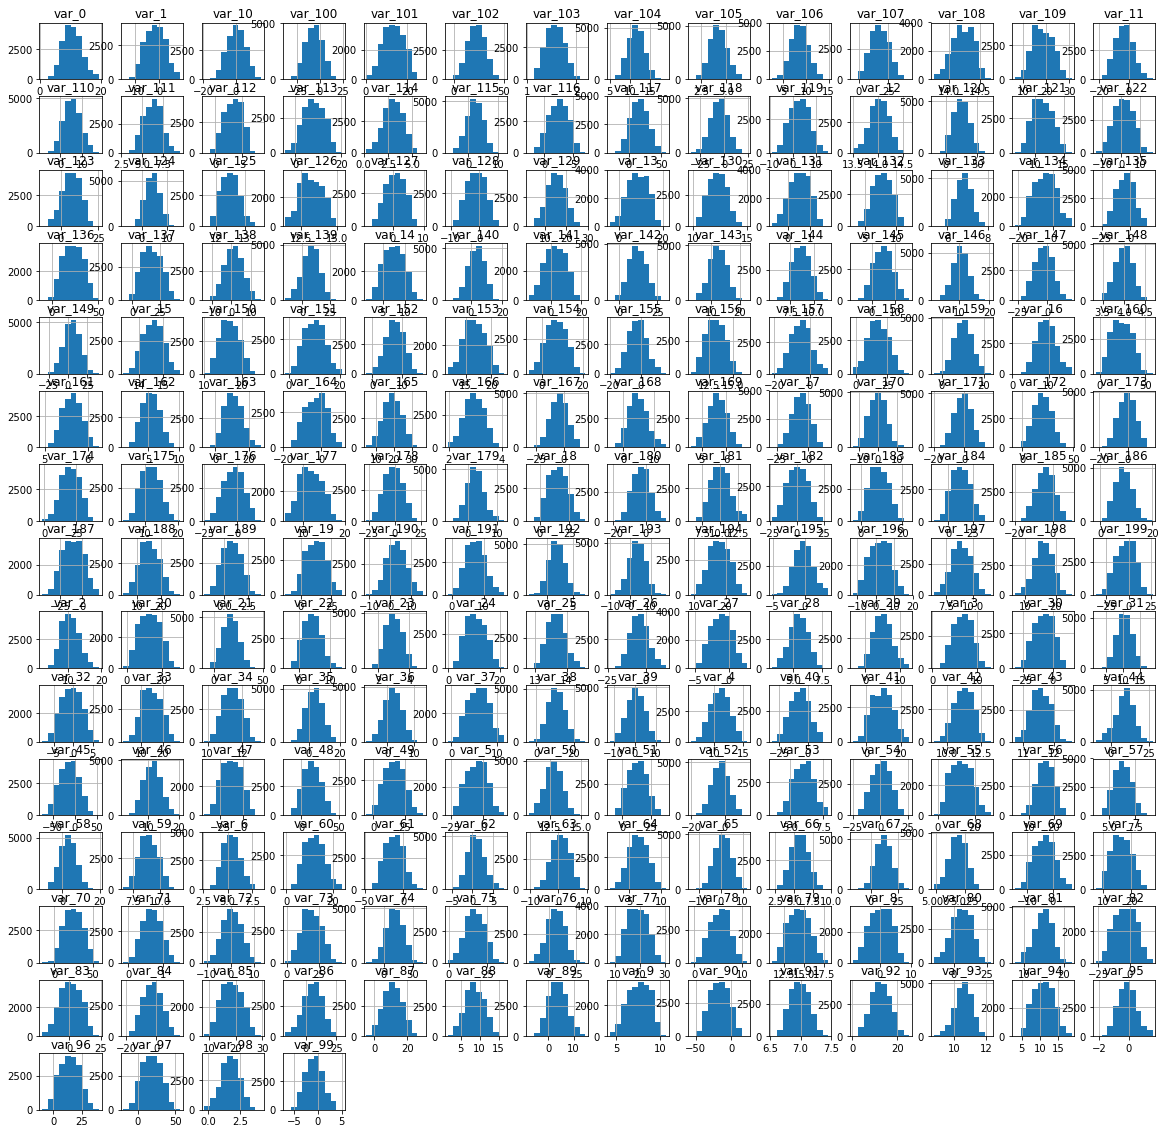

In [10]:
X.hist(figsize=(20,20))
plt.show()

In [11]:
print('Total number of NaN values in sample: ' + str(X.isna().sum().sum()))

Total number of NaN values in sample: 0


In [12]:
normality = [normaltest(X[i])[1] for i in X.columns]

In [13]:
pd.DataFrame(normality).describe()

,0
count,2.000000e+02
mean,3.860766e-17
std,5.422599e-16
min,0.000000e+00
25%,1.219037e-174
50%,5.912993e-86
75%,6.832984e-51
max,7.668885e-15


In [ ]:
xx - plot histogram of normality

(array([17983.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,  2017.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

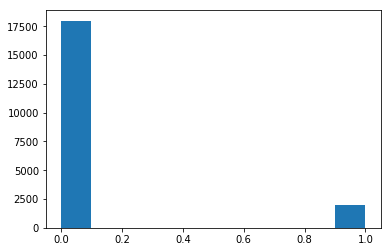

In [14]:
plt.hist(y)

A review of the data it contains both positive & negative values, a visual review of histograms of each of the predictors indicates that they are all relatively normal. This is confirmed with a normality test (which is based on Pearson's) where each distribution is compared to a normal distribution and p-value generated, indicating the probability that the distribution is normal.

It would appear that the data set is of a similar scale, however to be sure the data set will have the mean removed and scaled to unit variance.

In [15]:
sc = StandardScaler() 

X_scaled = sc.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled)
X_scaled.columns = X.columns

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, random_state=100, test_size=0.2)

## Pass 3

To further improve the normality of the data a quantile transform will be used

In [16]:
qt = QuantileTransformer(output_distribution='normal')
X_quant = qt.fit_transform(X_scaled)
X_quant = qt.transform(X_quant)

In [19]:
X_train_qt, X_test_qt, y_train_qt, y_test_qt = train_test_split(X_quant, y, random_state=100, test_size=0.2)

In [20]:
spw = float(len(y[y == 1])) / float(len(y[y == 0]))

### Conclusion

The data set is sufficiently clean and normal can be progressed with. A test will be created to ensure that when the rest of the dataset is included the traits indentified in this analysis are representative, a test fail will indicate that that sample taken here is not sufficiently representative of the entire dataset. 



# Explore / Model

### Function generation

Some key components will be used multiple times so they will be created as functions

**Confusion Matrix**

In [21]:
def confusion_mat(y, y_pred):
    cnf_matrix = confusion_matrix(y, y_pred)
    plt.imshow(cnf_matrix,  cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    class_names = set(y)
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)
    thresh = cnf_matrix.max() / 2.

    for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
        plt.text(j, i, cnf_matrix[i, j],
                 horizontalalignment="center",
                 color="white" if cnf_matrix[i, j] > thresh else "black")
    plt.colorbar()
    plt.show()

**AUC**

In [22]:
def AUC(y_train, y_pred_train, y_test, y_pred_test):
    fpr, tpr, thresholds = roc_curve(y_train, y_pred_train) 
    AUC_train = print('AUC train: ' + str(round(auc(fpr, tpr),4)))
    AUC_train
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_test) 
    AUC_test = print('AUC test: ' + str(round(auc(fpr, tpr),4)))
    AUC_test

In [23]:
def AUC_nonprint(y_train, y_pred_train, y_test, y_pred_test):
    fpr, tpr, thresholds = roc_curve(y_train, y_pred_train) 
    AUC_train = round(auc(fpr, tpr),4)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_test) 
    AUC_test = round(auc(fpr, tpr),4)
    return AUC_train, AUC_test

# Pass 1

Initially a simple model will be fitted to provide a bench mark for improvement

### KNearest Neighbours

In [24]:
clf_knn = KNeighborsClassifier(n_neighbors=3) 
clf_knn.fit(X_train, y_train) 
y_pred_train_knn = clf_knn.predict(X_train)
y_pred_test_knn = clf_knn.predict(X_test)

In [25]:
AUC(y_train, y_pred_train_knn, y_test, y_pred_test_knn)

AUC train: 0.5437
AUC test: 0.5015


## Decision Trees

In [26]:
clf_xgb_vanilla = xgb.XGBClassifier()
clf_xgb_vanilla.fit(X_train, y_train)
y_pred_train_xgb_vanilla = clf_xgb_vanilla.predict(X_train)
y_pred_test_xgb_vanilla = clf_xgb_vanilla.predict(X_test)

In [27]:
AUC(y_train, y_pred_train_xgb_vanilla, y_test, y_pred_test_xgb_vanilla)

AUC train: 0.5488
AUC test: 0.5082


**Conclusions**

In both models With an AUC of only marginally above the threshold of random chance, 0.5, the model performance here is very poor - significant work needs to be completed to have a useable model.

# Pass 2

Initial exploration of the some of the modelling parameters

### Weighting

**Use SMOTE as the weighting paramaeter**

In [28]:
print(y.value_counts())
print('X-Length' + str(len(X_scaled)))
X_train_smote, y_train_smote = SMOTE().fit_sample(X_train, y_train)
X_train_smote = pd.DataFrame(X_train_smote)
X_train_smote.columns = X.columns
print(pd.Series(y_train_smote).value_counts())
print('X-Length' + str(len(X_train_smote)))
print('Y-Length' + str(len(y_train_smote)))

0    17983
1     2017
Name: target, dtype: int64
X-Length20000
1    14411
0    14411
dtype: int64
X-Length28822
Y-Length28822


In [29]:
clf_xgb_smote = xgb.XGBClassifier()
clf_xgb_smote.fit(X_train_smote, y_train_smote)
y_pred_train_xgb_smote = clf_xgb_smote.predict(X_train)
y_pred_test_xgb_smote = clf_xgb_smote.predict(X_test)

AUC train: 0.7422
AUC test: 0.5807


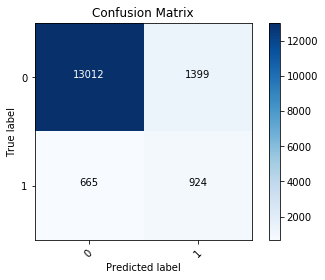

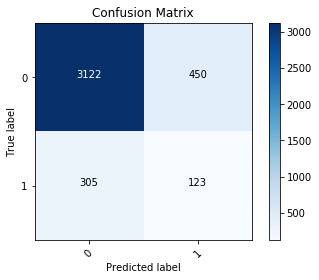

In [30]:
AUC(y_train, y_pred_train_xgb_smote, y_test, y_pred_test_xgb_smote)
confusion_mat(y_train, y_pred_train_xgb_smote)
confusion_mat(y_test, y_pred_test_xgb_smote)

**Using in built parameter**

In [31]:
I = range(2,30,2)
AUC_train_weight_results = []
AUC_test_weight_results =[]
for i in range(2,30,2):
    clf_xgb_weight = xgb.XGBClassifier(scale_pos_weight=i)
    clf_xgb_weight.fit(X_train, y_train)
    y_pred_train_xgb_weight = clf_xgb_weight.predict(X_train)
    y_pred_test_xgb_weight = clf_xgb_weight.predict(X_test)
    AUC_train, AUC_test = AUC_nonprint(y_train, y_pred_train_xgb_weight, y_test, y_pred_test_xgb_weight)
    AUC_train_weight_results.append(AUC_train)
    AUC_test_weight_results.append(AUC_test)

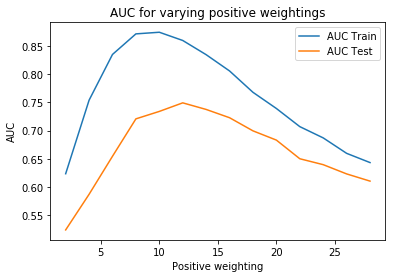

In [32]:
plt.plot(I, AUC_train_weight_results, label='AUC Train')
plt.plot(I, AUC_test_weight_results, label= 'AUC Test')
plt.title('AUC for varying positive weightings')
plt.xlabel('Positive weighting')
plt.ylabel('AUC')
plt.legend()
plt.show()

**Conclusion**

The weighting peaks around 13 for testing, so for the Grid Search using an initial range of values from 10-15 would seem appropriate. Using the inbuilt parameter produces better results than the SMOTE method. There is a significant degree of overfitting in all models.

AUC train: 0.8469
AUC test: 0.7537


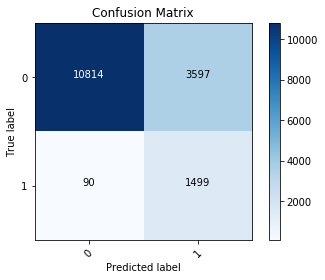

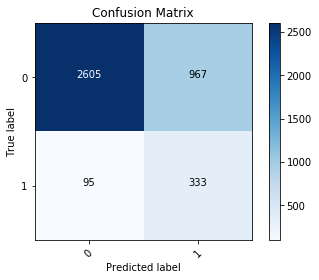

In [33]:
clf_xgb_weight = xgb.XGBClassifier(scale_pos_weight=13)
clf_xgb_weight.fit(X_train, y_train)
y_pred_train_xgb_weight = clf_xgb_weight.predict(X_train)
y_pred_test_xgb_weight = clf_xgb_weight.predict(X_test)
AUC(y_train, y_pred_train_xgb_weight, y_test, y_pred_test_xgb_weight)
confusion_mat(y_train, y_pred_train_xgb_weight)
confusion_mat(y_test, y_pred_test_xgb_weight)

### Max Depth

In [35]:
I = range(1,30,2)
AUC_train_max_depth_results = []
AUC_test_max_depth_results =[]
for i in I:
    clf_xgb_max_depth = xgb.XGBClassifier(
        max_depth = i,
        scale_pos_weight=13,
    )
    clf_xgb_max_depth.fit(X_train, y_train)
    y_pred_train_xgb_max_depth = clf_xgb_max_depth.predict(X_train)
    y_pred_test_xgb_max_depth = clf_xgb_max_depth.predict(X_test)
    AUC_train, AUC_test = AUC_nonprint(y_train, y_pred_train_xgb_max_depth, y_test, y_pred_test_xgb_max_depth)
    AUC_train_max_depth_results.append(AUC_train)
    AUC_test_max_depth_results.append(AUC_test)

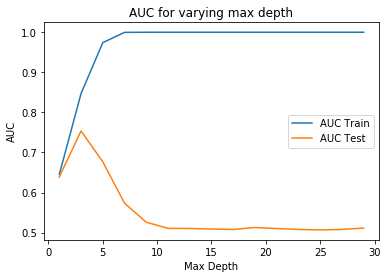

In [36]:
plt.plot(I, AUC_train_max_depth_results, label='AUC Train')
plt.plot(I, AUC_test_max_depth_results, label= 'AUC Test')
plt.title('AUC for varying max depth')
plt.xlabel('Max Depth')
plt.ylabel('AUC')
plt.legend()
plt.show()

**Conclusion**

Although the train AUC tends toward 1 with increasing depth, the test rapdidly decreased after a depth of approximately 4 a clear sign of overfitting. For the grid search the max depth values used will be 3, 4 and 5.

### Model Evaluation Criteria

AUC train: 0.8469
AUC test: 0.7537


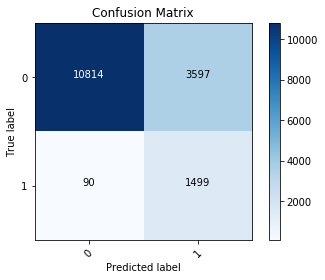

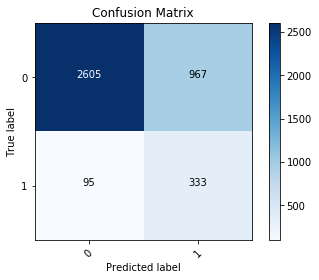

In [37]:
clf_xgb_eval = xgb.XGBClassifier(scale_pos_weight=13, eval_metric = 'auc')
clf_xgb_eval.fit(X_train, y_train)
y_pred_train_xgb_eval = clf_xgb_eval.predict(X_train)
y_pred_test_xgb_eval = clf_xgb_eval.predict(X_test)
AUC(y_train, y_pred_train_xgb_eval, y_test, y_pred_test_xgb_eval)
confusion_mat(y_train, y_pred_train_xgb_eval)
confusion_mat(y_test, y_pred_test_xgb_eval)

**Conclusion**
No difference, model may well have already predefined this as the evaluation criteria

### Minimum Split Loss

In [38]:
I = range(0,30,3)
AUC_train_gamma_results = []
AUC_test_gamma_results =[]
for i in I:
    clf_xgb_gamma = xgb.XGBClassifier(
        scale_pos_weight=13,
        gamma = i
    )
    clf_xgb_gamma.fit(X_train, y_train)
    y_pred_train_xgb_gamma = clf_xgb_gamma.predict(X_train)
    y_pred_test_xgb_gamma = clf_xgb_gamma.predict(X_test)
    AUC_train, AUC_test = AUC_nonprint(y_train, y_pred_train_xgb_gamma, y_test, y_pred_test_xgb_gamma)
    AUC_train_gamma_results.append(AUC_train)
    AUC_test_gamma_results.append(AUC_test)

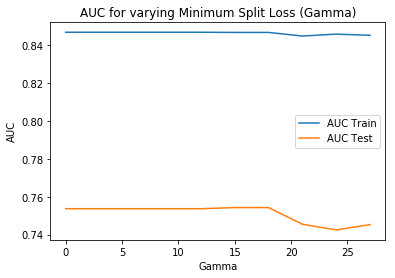

In [39]:
plt.plot(I, AUC_train_gamma_results, label='AUC Train')
plt.plot(I, AUC_test_gamma_results, label= 'AUC Test')
plt.title('AUC for varying Minimum Split Loss (Gamma)')
plt.xlabel('Gamma')
plt.ylabel('AUC')
plt.legend()
plt.show()

**Conclusion**

XX - include

## Pass 3 

### Building a basic model

At this point will swap to the xgb .train method rather than the scikit .fit method as this gives greater control. The main aim of this section is to optimise further the parameters, first step will be identify the number of rounds that should be completed - the aim is to minimise the number. The quantile transformed dataset will be used.

**Model setup**

In [40]:
train_data = xgb.DMatrix(data=X_train_qt, label=y_train)
valid_data = xgb.DMatrix(data=X_test_qt, label=y_test)
watchlist = [(train_data, 'train'), (valid_data, 'valid_data')]

In [41]:
model_params = {
    'scale_pos_weight': 13,
    'gamma': 2,
    'max_depth': 1,
    'verbosity': 0, 
    'silent': True,
    'eval_metric': 'auc'
}

In [44]:
start = time.time()
tr_model = xgb.train(
        dtrain=train_data,
        num_boost_round=100000,
        evals=watchlist,
        early_stopping_rounds=4000,
        verbose_eval=2000,
        params=model_params)

print('Duration: ' +str(round(time.time()-start,4)) + 'secs')

[0]	train-auc:0.552023	valid_data-auc:0.546484
Multiple eval metrics have been passed: 'valid_data-auc' will be used for early stopping.

Will train until valid_data-auc hasn't improved in 4000 rounds.
[2000]	train-auc:0.965218	valid_data-auc:0.864003
[4000]	train-auc:0.965218	valid_data-auc:0.864003
Stopping. Best iteration:
[695]	train-auc:0.959788	valid_data-auc:0.865413

Duration: 525.5425secs


In [46]:
start = time.time()
tr_model = xgb.train(
        dtrain=train_data,
        num_boost_round=10000,
        evals=watchlist,
        early_stopping_rounds=400,
        verbose_eval=100,
        params=model_params)

print('Duration: ' +str(round(time.time()-start,4)) + 'secs')

[0]	train-auc:0.552023	valid_data-auc:0.546484
Multiple eval metrics have been passed: 'valid_data-auc' will be used for early stopping.

Will train until valid_data-auc hasn't improved in 400 rounds.
[100]	train-auc:0.879516	valid_data-auc:0.829423
[200]	train-auc:0.91479	valid_data-auc:0.851685
[300]	train-auc:0.931898	valid_data-auc:0.860228
[400]	train-auc:0.943543	valid_data-auc:0.862927
[500]	train-auc:0.951019	valid_data-auc:0.864671
[600]	train-auc:0.95598	valid_data-auc:0.863158
[700]	train-auc:0.959963	valid_data-auc:0.865206
[800]	train-auc:0.963413	valid_data-auc:0.864257
[900]	train-auc:0.965218	valid_data-auc:0.864003
[1000]	train-auc:0.965218	valid_data-auc:0.864003
Stopping. Best iteration:
[695]	train-auc:0.959788	valid_data-auc:0.865413

Duration: 122.3475secs


**Conclusion**

Both of the above methods return the same AUC value, with the same output. However the second option greatly decreased the processing time. As a result the second set of model run hyperparameters will be used.

## Optimisation of base model

### Deployable code for Parameter Optimisation

With the large number of parameters and combindations an exhaustive Grid Search is going to be computationally extremely demanding as such an approach of staged optimisation will be used - as each pararmeter is optimised that parameter will be carried forwards.

There are some limitation to this method, as discussed above in that some parameters are co-dependent so the best for one is not necessarily the best for the second. Once this initial optimisation is complete, additional optimisations will be conducted.

The order of the parameters has been selected to include parameters likely to have a large effect first.

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import gc
from sklearn.preprocessing import StandardScaler, QuantileTransformer
import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc

df = pd.read_csv('sample.csv', index_col = 'ID_code')

sc = StandardScaler()
X_scaled = sc.fit_transform(df.drop('target',axis=1))
X_scaled = pd.DataFrame(X_scaled)
X_scaled.columns = df.drop('target',axis=1).columns

qt = QuantileTransformer(output_distribution='normal')
X_quant = qt.fit_transform(X_scaled)
X_quant = qt.transform(X_quant)

X_train, X_test, y_train, y_test = train_test_split(X_quant, df.target, random_state=100, test_size=0.2)

train_data = xgb.DMatrix(data=X_train, label=y_train)
valid_data = xgb.DMatrix(data=X_test, label=y_test)
watchlist = [(train_data, 'train'), (valid_data, 'valid_data')]


def AUC(y_train, y_pred_train, y_test, y_pred_test):
    fpr, tpr, thresholds = roc_curve(y_train, y_pred_train)
    AUC_train = round(auc(fpr, tpr),4)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_test)
    AUC_test = round(auc(fpr, tpr),4)
    return AUC_train, AUC_test

spw = float(len(y_train[y_train == 1])) / float(len(y_train[y_train == 0]))


I = [1/spw, 12.7, 12.8, 12.9] # scale_pos_weight difference between the positive and negative classes
J = [1,2] # max_depth
K = [0.01, 0.02, 0.03] # eta/learning rate
L = [0.25, 0.29, 0.35] # subsample
M = [0.03, 0.04, 0.05] # colsample_bytree
N = [0.55, 0.57, 0.59] # lambda L2 regularisation term on weights - Ridge
P = [0.06, 0.08, 0.1] # alpha L1 regularisation term on weights - Lasso
Q = [4.5, 5.45, 6.5] # min_child_weight range 0-inf,
R= [1.25, 1.53, 1.75] # max_delta_step range 0-inf, useful in highly imbalance class sets
#Provide some initial values
i_best = 13
j_best = 1
k_best = 0.01
l_best = 0.25
m_best = 0.03
n_best = 0.55
p_best = 0.06
q_best = 4.5
r_best = 1.25


results = []
current_auc_best = 0
for i in I:
    model_params = {
        'scale_pos_weight': i, # difference between the positive and negative classes
        'max_depth': j_best,
        'eta': k_best, #Learning rate
        'subsample': l_best,  #Reduces overfitting, range 0-1, 0.5-0.5 would be 50% training data
        'colsample_bytree': m_best, # range 0-1
        'lambda': n_best, # L2 regularisation term on weights - Ridge
        'alpha': p_best, # L1 regularisation term on weights - Lasso
        'min_child_weight': q_best, # range 0-inf,
        'max_delta_step': r_best, # range 0-inf, useful in highly imbalance class sets
        'objective': 'binary:logistic', # model type
        'eval_metric': 'auc', # evaulation type
        'verbosity': 0, #printing of messages 0 (silent), 1 (warning), 2 (info), 3 (debug)
        'silent': True #Depricated use verbosity - although does stop lots of messages
                }
    tr_model = xgb.train(
        dtrain=train_data,
        num_boost_round=10000,
        evals=watchlist,
        early_stopping_rounds=400,
        verbose_eval=100,
        params=model_params)
    y_pred_train = tr_model.predict(xgb.DMatrix(X_train), ntree_limit=tr_model.best_ntree_limit)
    y_pred_test = tr_model.predict(xgb.DMatrix(X_test), ntree_limit=tr_model.best_ntree_limit)
    auc_train, auc_test = AUC(y_train, y_pred_train, y_test, y_pred_test)
    current_auc_best = 0
    if auc_test>current_auc_best:
        current_auc_best = auc_test
        i_best = i
    print(' i: '+str(i) + ' j: ' +str(j_best), ' k: ' +str(k_best) + ' l:' +str(l_best), ' m: ' +str(m_best) + ' n: ' +str(n_best) +' p: ' +str(p_best) + ' q: ' +str(q_best) + ' r: '+str(r_best) +' AUC Train: ' +str(auc_train)+' AUC Test: ' +str(auc_test))
    results.append({'i':i, 'j':j_best, 'k':k_best, 'l':l_best, 'm':m_best, 'n':n_best, 'p':p_best, 'q':q_best, 'r':r_best, 'AUC_train':auc_train, 'AUC_test': auc_test})

for j in J:
    model_params = {
        'scale_pos_weight': i_best, # difference between the positive and negative classes
        'max_depth': j,
        'eta': k_best, #Learning rate
        'subsample': l_best,  #Reduces overfitting, range 0-1, 0.5-0.5 would be 50% training data
        'colsample_bytree': m_best, # range 0-1
        'lambda': n_best, # L2 regularisation term on weights - Ridge
        'alpha': p_best, # L1 regularisation term on weights - Lasso
        'min_child_weight': q_best, # range 0-inf,
        'max_delta_step': r_best, # range 0-inf, useful in highly imbalance class sets
        'objective': 'binary:logistic', # model type
        'eval_metric': 'auc', # evaulation type
        'verbosity': 0, #printing of messages 0 (silent), 1 (warning), 2 (info), 3 (debug)
        'silent': True #Depricated use verbosity - although does stop lots of messages
                }
    tr_model = xgb.train(
        dtrain=train_data,
        num_boost_round=10000,
        evals=watchlist,
        early_stopping_rounds=400,
        verbose_eval=100,
        params=model_params)
    y_pred_train = tr_model.predict(xgb.DMatrix(X_train), ntree_limit=tr_model.best_ntree_limit)
    y_pred_test = tr_model.predict(xgb.DMatrix(X_test), ntree_limit=tr_model.best_ntree_limit)
    auc_train, auc_test = AUC(y_train, y_pred_train, y_test, y_pred_test)
    if auc_test>current_auc_best:
        current_auc_best = auc_test
        j_best = j
    print(' i: '+str(i_best) + ' j: ' +str(j), ' k: ' +str(k_best) + ' l:' +str(l_best), ' m: ' +str(m_best) + ' n: ' +str(n_best) +' p: ' +str(p_best) + ' q: ' +str(q_best) + ' r: '+str(r_best) +' AUC Train: ' +str(auc_train)+' AUC Test: ' +str(auc_test))
    results.append({'i':i_best, 'j':j, 'k':k_best, 'l':l_best, 'm':m_best, 'n':n_best, 'p':p_best, 'q':q_best, 'r':r_best, 'AUC_train':auc_train, 'AUC_test': auc_test})

current_auc_best = 0
for k in K:
    model_params = {
        'scale_pos_weight': i_best, # difference between the positive and negative classes
        'max_depth': j_best,
        'eta': k, #Learning rate
        'subsample': l_best,  #Reduces overfitting, range 0-1, 0.5-0.5 would be 50% training data
        'colsample_bytree': m_best, # range 0-1
        'lambda': n_best, # L2 regularisation term on weights - Ridge
        'alpha': p_best, # L1 regularisation term on weights - Lasso
        'min_child_weight': q_best, # range 0-inf,
        'max_delta_step': r_best, # range 0-inf, useful in highly imbalance class sets
        'objective': 'binary:logistic', # model type
        'eval_metric': 'auc', # evaulation type
        'verbosity': 0, #printing of messages 0 (silent), 1 (warning), 2 (info), 3 (debug)
        'silent': True #Depricated use verbosity - although does stop lots of messages
                }
    tr_model = xgb.train(
        dtrain=train_data,
        num_boost_round=10000,
        evals=watchlist,
        early_stopping_rounds=400,
        verbose_eval=100,
        params=model_params)
    y_pred_train = tr_model.predict(xgb.DMatrix(X_train), ntree_limit=tr_model.best_ntree_limit)
    y_pred_test = tr_model.predict(xgb.DMatrix(X_test), ntree_limit=tr_model.best_ntree_limit)
    auc_train, auc_test = AUC(y_train, y_pred_train, y_test, y_pred_test)
    if auc_test>current_auc_best:
        current_auc_best = auc_test
        k_best = k
    print(' i: '+str(i_best) + ' j: ' +str(j_best), ' k: ' +str(k) + ' l:' +str(l_best), ' m: ' +str(m_best) + ' n: ' +str(n_best) +' p: ' +str(p_best) + ' q: ' +str(q_best) + ' r: '+str(r_best) +' AUC Train: ' +str(auc_train)+' AUC Test: ' +str(auc_test))
    results.append({'i':i_best, 'j':j_best, 'k':k, 'l':l_best, 'm':m_best, 'n':n_best, 'p':p_best, 'q':q_best, 'r':r_best, 'AUC_train':auc_train, 'AUC_test': auc_test})

current_auc_best = 0
for l in L:
    model_params = {
        'scale_pos_weight': i_best, # difference between the positive and negative classes
        'max_depth': j_best,
        'eta': k_best, #Learning rate
        'subsample': l,  #Reduces overfitting, range 0-1, 0.5-0.5 would be 50% training data
        'colsample_bytree': m_best, # range 0-1
        'lambda': n_best, # L2 regularisation term on weights - Ridge
        'alpha': p_best, # L1 regularisation term on weights - Lasso
        'min_child_weight': q_best, # range 0-inf,
        'max_delta_step': r_best, # range 0-inf, useful in highly imbalance class sets
        'objective': 'binary:logistic', # model type
        'eval_metric': 'auc', # evaulation type
        'verbosity': 0, #printing of messages 0 (silent), 1 (warning), 2 (info), 3 (debug)
        'silent': True #Depricated use verbosity - although does stop lots of messages
                }
    tr_model = xgb.train(
        dtrain=train_data,
        num_boost_round=10000,
        evals=watchlist,
        early_stopping_rounds=400,
        verbose_eval=100,
        params=model_params)
    y_pred_train = tr_model.predict(xgb.DMatrix(X_train), ntree_limit=tr_model.best_ntree_limit)
    y_pred_test = tr_model.predict(xgb.DMatrix(X_test), ntree_limit=tr_model.best_ntree_limit)
    auc_train, auc_test = AUC(y_train, y_pred_train, y_test, y_pred_test)
    if auc_test>current_auc_best:
        current_auc_best = auc_test
        l_best = l
    print(' i: '+str(i_best) + ' j: ' +str(j_best), ' k: ' +str(k_best) + ' l:' +str(l), ' m: ' +str(m_best) + ' n: ' +str(n_best) +' p: ' +str(p_best) + ' q: ' +str(q_best) + ' r: '+str(r_best) +' AUC Train: ' +str(auc_train)+' AUC Test: ' +str(auc_test))
    results.append({'i':i_best, 'j':j_best, 'k':k_best, 'l':l, 'm':m_best, 'n':n_best, 'p':p_best, 'q':q_best, 'r':r_best, 'AUC_train':auc_train, 'AUC_test': auc_test})

current_auc_best = 0
for m in M:
    model_params = {
        'scale_pos_weight': i_best, # difference between the positive and negative classes
        'max_depth': j_best,
        'eta': k_best, #Learning rate
        'subsample': l,  #Reduces overfitting, range 0-1, 0.5-0.5 would be 50% training data
        'colsample_bytree': m_best, # range 0-1
        'lambda': n_best, # L2 regularisation term on weights - Ridge
        'alpha': p_best, # L1 regularisation term on weights - Lasso
        'min_child_weight': q_best, # range 0-inf,
        'max_delta_step': r_best, # range 0-inf, useful in highly imbalance class sets
        'objective': 'binary:logistic', # model type
        'eval_metric': 'auc', # evaulation type
        'verbosity': 0, #printing of messages 0 (silent), 1 (warning), 2 (info), 3 (debug)
        'silent': True #Depricated use verbosity - although does stop lots of messages
                }
    tr_model = xgb.train(
        dtrain=train_data,
        num_boost_round=10000,
        evals=watchlist,
        early_stopping_rounds=400,
        verbose_eval=100,
        params=model_params)
    y_pred_train = tr_model.predict(xgb.DMatrix(X_train), ntree_limit=tr_model.best_ntree_limit)
    y_pred_test = tr_model.predict(xgb.DMatrix(X_test), ntree_limit=tr_model.best_ntree_limit)
    auc_train, auc_test = AUC(y_train, y_pred_train, y_test, y_pred_test)
    if auc_test>current_auc_best:
        current_auc_best = auc_test
        m_best = m
    print(' i: '+str(i_best) + ' j: ' +str(j_best), ' k: ' +str(k_best) + ' l:' +str(l_best), ' m: ' +str(m) + ' n: ' +str(n_best) +' p: ' +str(p_best) + ' q: ' +str(q_best) + ' r: '+str(r_best) +' AUC Train: ' +str(auc_train)+' AUC Test: ' +str(auc_test))
    results.append({'i':i_best, 'j':j_best, 'k':k_best, 'l':l_best, 'm':m, 'n':n_best, 'p':p_best, 'q':q_best, 'r':r_best, 'AUC_train':auc_train, 'AUC_test': auc_test})

current_auc_best = 0
for n in N:
    model_params = {
        'scale_pos_weight': i_best, # difference between the positive and negative classes
        'max_depth': j_best,
        'eta': k_best, #Learning rate
        'subsample': l_best,  #Reduces overfitting, range 0-1, 0.5-0.5 would be 50% training data
        'colsample_bytree': m_best, # range 0-1
        'lambda': n, # L2 regularisation term on weights - Ridge
        'alpha': p_best, # L1 regularisation term on weights - Lasso
        'min_child_weight': q_best, # range 0-inf,
        'max_delta_step': r_best, # range 0-inf, useful in highly imbalance class sets
        'objective': 'binary:logistic', # model type
        'eval_metric': 'auc', # evaulation type
        'verbosity': 0, #printing of messages 0 (silent), 1 (warning), 2 (info), 3 (debug)
        'silent': True #Depricated use verbosity - although does stop lots of messages
                }
    tr_model = xgb.train(
        dtrain=train_data,
        num_boost_round=10000,
        evals=watchlist,
        early_stopping_rounds=400,
        verbose_eval=100,
        params=model_params)
    y_pred_train = tr_model.predict(xgb.DMatrix(X_train), ntree_limit=tr_model.best_ntree_limit)
    y_pred_test = tr_model.predict(xgb.DMatrix(X_test), ntree_limit=tr_model.best_ntree_limit)
    auc_train, auc_test = AUC(y_train, y_pred_train, y_test, y_pred_test)
    if auc_test>current_auc_best:
        current_auc_best = auc_test
        n_best = n
    print(' i: '+str(i_best) + ' j: ' +str(j_best), ' k: ' +str(k_best) + ' l:' +str(l_best), ' m: ' +str(m_best) + ' n: ' +str(n) +' p: ' +str(p_best) + ' q: ' +str(q_best) + ' r: '+str(r_best) +' AUC Train: ' +str(auc_train)+' AUC Test: ' +str(auc_test))
    results.append({'i':i_best, 'j':j_best, 'k':k_best, 'l':l_best, 'm':m_best, 'n':n, 'p':p_best, 'q':q_best, 'r':r_best, 'AUC_train':auc_train, 'AUC_test': auc_test})

current_auc_best = 0
for p in P:
    model_params = {
        'scale_pos_weight': i_best, # difference between the positive and negative classes
        'max_depth': j_best,
        'eta': k_best, #Learning rate
        'subsample': l_best,  #Reduces overfitting, range 0-1, 0.5-0.5 would be 50% training data
        'colsample_bytree': m_best, # range 0-1
        'lambda': n_best, # L2 regularisation term on weights - Ridge
        'alpha': p, # L1 regularisation term on weights - Lasso
        'min_child_weight': q_best, # range 0-inf,
        'max_delta_step': r_best, # range 0-inf, useful in highly imbalance class sets
        'objective': 'binary:logistic', # model type
        'eval_metric': 'auc', # evaulation type
        'verbosity': 0, #printing of messages 0 (silent), 1 (warning), 2 (info), 3 (debug)
        'silent': True #Depricated use verbosity - although does stop lots of messages
                }
    tr_model = xgb.train(
        dtrain=train_data,
        num_boost_round=10000,
        evals=watchlist,
        early_stopping_rounds=400,
        verbose_eval=100,
        params=model_params)
    y_pred_train = tr_model.predict(xgb.DMatrix(X_train), ntree_limit=tr_model.best_ntree_limit)
    y_pred_test = tr_model.predict(xgb.DMatrix(X_test), ntree_limit=tr_model.best_ntree_limit)
    auc_train, auc_test = AUC(y_train, y_pred_train, y_test, y_pred_test)
    if auc_test>current_auc_best:
        current_auc_best = auc_test
        p_best = p
    print(' i: '+str(i_best) + ' j: ' +str(j_best), ' k: ' +str(k_best) + ' l:' +str(l_best), ' m: ' +str(m_best) + ' n: ' +str(n_best) +' p: ' +str(p) + ' q: ' +str(q_best) + ' r: '+str(r_best) +' AUC Train: ' +str(auc_train)+' AUC Test: ' +str(auc_test))
    results.append({'i':i_best, 'j':j_best, 'k':k_best, 'l':l_best, 'm':m_best, 'n':n_best, 'p':p, 'q':q_best, 'r':r_best, 'AUC_train':auc_train, 'AUC_test': auc_test})

current_auc_best = 0
for q in Q:
    model_params = {
        'scale_pos_weight': i_best, # difference between the positive and negative classes
        'max_depth': j_best,
        'eta': k_best, #Learning rate
        'subsample': l_best,  #Reduces overfitting, range 0-1, 0.5-0.5 would be 50% training data
        'colsample_bytree': m_best, # range 0-1
        'lambda': n_best, # L2 regularisation term on weights - Ridge
        'alpha': p_best, # L1 regularisation term on weights - Lasso
        'min_child_weight': q, # range 0-inf,
        'max_delta_step': r_best, # range 0-inf, useful in highly imbalance class sets
        'objective': 'binary:logistic', # model type
        'eval_metric': 'auc', # evaulation type
        'verbosity': 0, #printing of messages 0 (silent), 1 (warning), 2 (info), 3 (debug)
        'silent': True #Depricated use verbosity - although does stop lots of messages
                }
    tr_model = xgb.train(
        dtrain=train_data,
        num_boost_round=10000,
        evals=watchlist,
        early_stopping_rounds=400,
        verbose_eval=100,
        params=model_params)
    y_pred_train = tr_model.predict(xgb.DMatrix(X_train), ntree_limit=tr_model.best_ntree_limit)
    y_pred_test = tr_model.predict(xgb.DMatrix(X_test), ntree_limit=tr_model.best_ntree_limit)
    auc_train, auc_test = AUC(y_train, y_pred_train, y_test, y_pred_test)
    if auc_test>current_auc_best:
        current_auc_best = auc_test
        q_best = q
    print(' i: '+str(i_best) + ' j: ' +str(j_best), ' k: ' +str(k_best) + ' l:' +str(l_best), ' m: ' +str(m_best) + ' n: ' +str(n_best) +' p: ' +str(p_best) + ' q: ' +str(q) + ' r: '+str(r_best) +' AUC Train: ' +str(auc_train)+' AUC Test: ' +str(auc_test))
    results.append({'i':i_best, 'j':j_best, 'k':k_best, 'l':l_best, 'm':m_best, 'n':n_best, 'p':p_best, 'q':q, 'r':r_best, 'AUC_train':auc_train, 'AUC_test': auc_test})

current_auc_best = 0
for r in R:
    model_params = {
        'scale_pos_weight': i_best, # difference between the positive and negative classes
        'max_depth': j_best,
        'eta': k_best, #Learning rate
        'subsample': l_best,  #Reduces overfitting, range 0-1, 0.5-0.5 would be 50% training data
        'colsample_bytree': m_best, # range 0-1
        'lambda': n_best, # L2 regularisation term on weights - Ridge
        'alpha': p_best, # L1 regularisation term on weights - Lasso
        'min_child_weight': q_best, # range 0-inf,
        'max_delta_step': r, # range 0-inf, useful in highly imbalance class sets
        'objective': 'binary:logistic', # model type
        'eval_metric': 'auc', # evaulation type
        'verbosity': 0, #printing of messages 0 (silent), 1 (warning), 2 (info), 3 (debug)
        'silent': True #Depricated use verbosity - although does stop lots of messages
                }
    tr_model = xgb.train(
        dtrain=train_data,
        num_boost_round=10000,
        evals=watchlist,
        early_stopping_rounds=400,
        verbose_eval=100,
        params=model_params)
    y_pred_train = tr_model.predict(xgb.DMatrix(X_train), ntree_limit=tr_model.best_ntree_limit)
    y_pred_test = tr_model.predict(xgb.DMatrix(X_test), ntree_limit=tr_model.best_ntree_limit)
    auc_train, auc_test = AUC(y_train, y_pred_train, y_test, y_pred_test)
    
    if auc_test>current_auc_best:
        current_auc_best = auc_test
        r_best = r
    print(' i: '+str(i_best) + ' j: ' +str(j_best), ' k: ' +str(k_best) + ' l:' +str(l_best), ' m: ' +str(m_best) + ' n: ' +str(n_best) +' p: ' +str(p_best) + ' q: ' +str(q_best) + ' r: '+str(r) +' AUC Train: ' +str(auc_train)+' AUC Test: ' +str(auc_test))
    results.append({'i':i_best, 'j':j_best, 'k':k_best, 'l':l_best, 'm':m_best, 'n':n_best, 'p':p_best, 'q':q_best, 'r':r, 'AUC_train':auc_train, 'AUC_test': auc_test})

pd.DataFrame(results).to_csv('search_results.csv')


In [47]:
results_table = pd.read_csv('optimisation_run2.csv', index_col='Unnamed: 0') 

In [48]:
results_table.sort_values('AUC_test', ascending=False)[:5]

,AUC_test,AUC_train,i,j,k,l,m,n,p,q,r
0,0.8765,0.9307,9.069226,1,0.01,0.25,0.03,0.55,0.06,4.50,1.25
20,0.8749,0.9329,12.900000,1,0.01,0.29,0.03,0.57,0.10,4.50,1.25
25,0.8749,0.9329,12.900000,1,0.01,0.29,0.03,0.57,0.10,4.50,1.53
24,0.8749,0.9329,12.900000,1,0.01,0.29,0.03,0.57,0.10,4.50,1.25
22,0.8749,0.9329,12.900000,1,0.01,0.29,0.03,0.57,0.10,5.45,1.25


### Model Setup Optimisation  Round 2

Based on the outputs of the parameter selection model the follow parameter are being retested for sensitivity

In [49]:
I = [1/spw] # scale_pos_weight difference between the positive and negative classes
J = [1,2] # max_depth
K = [0.01, 0.02, 0.03] # eta/learning rate
L = [0.25, 0.8] # subsample
M = [0.03, 0.04, 0.05] # colsample_bytree
N = [0.55, 0.25, 0.75] # lambda L2 regularisation term on weights - Ridge
P = [0.1, 0.15, 0.2] # alpha L1 regularisation term on weights - Lasso
Q = [4.5, 3.5] # min_child_weight range 0-inf,
R= [1.25, 1, 0.5] # max_delta_step range 0-inf, useful in highly imbalance class sets
#Provide some initial values
i_best = 1/spw
j_best = 1
k_best = 0.01
l_best = 0.25 # some variation
m_best = 0.03
n_best = 0.55 # some variation
p_best = 0.10
q_best = 4.5
r_best = 1.25

In [50]:
results_table = pd.read_csv('optimisation_run3.csv', index_col='Unnamed: 0')

In [51]:
results_table.sort_values('AUC_test', ascending=False)[:5]

,AUC_test,AUC_train,i,j,k,l,m,n,p,q,r
20,0.8775,0.9455,9.069226,1,0.03,0.25,0.03,0.75,0.15,4.5,0.50
19,0.8775,0.9455,9.069226,1,0.03,0.25,0.03,0.75,0.15,4.5,1.00
18,0.8775,0.9455,9.069226,1,0.03,0.25,0.03,0.75,0.15,4.5,1.25
16,0.8775,0.9455,9.069226,1,0.03,0.25,0.03,0.75,0.15,4.5,1.25
14,0.8775,0.9455,9.069226,1,0.03,0.25,0.03,0.75,0.15,4.5,1.25


### Optimisation Round 3

In [ ]:
I = [1/spw] # scale_pos_weight difference between the positive and negative classes
J = [1] # max_depth
K = [0.01, 0.05] # eta/learning rate
L = [0.25] # subsample
M = [0.03, 0.04, 0.05] # colsample_bytree
N = [0.75, 0.6, 0.85] # lambda L2 regularisation term on weights - Ridge
P = [0.13, 0.15, 0.17] # alpha L1 regularisation term on weights - Lasso
Q = [4.5, 5] # min_child_weight range 0-inf,
R= [1.25,] # max_delta_step range 0-inf, useful in highly imbalance class sets
#Provide some initial values
i_best = 1/spw
j_best = 1
k_best = 0.01
l_best = 0.25 # some variation
m_best = 0.03
n_best = 0.55 # some variation
p_best = 0.10
q_best = 4.5
r_best = 1.25

In [52]:
results_table = pd.read_csv('optimisation_run4.csv', index_col='Unnamed: 0')

In [53]:
results_table.sort_values('AUC_test', ascending=False)[:5]

,AUC_test,AUC_train,i,j,k,l,m,n,p,q,r
0,0.8767,0.9333,9.069226,1,0.01,0.25,0.03,0.55,0.10,4.5,1.25
12,0.8738,0.9313,12.900000,1,0.01,0.25,0.03,0.75,0.13,4.5,1.25
16,0.8738,0.9313,12.900000,1,0.01,0.25,0.03,0.75,0.13,5.0,1.25
15,0.8738,0.9313,12.900000,1,0.01,0.25,0.03,0.75,0.13,4.5,1.25
9,0.8738,0.9306,12.900000,1,0.01,0.25,0.03,0.75,0.10,4.5,1.25


### Optimisation Round 4

In [ ]:
I = [1/spw] # scale_pos_weight difference between the positive and negative classes
J = [1,2] # max_depth
K = [0.01, 0.02, 0.03] # eta/learning rate
L = [0.25, 0.8] # subsample
M = [0.03, 0.04, 0.05] # colsample_bytree
N = [0.55, 0.25, 0.75] # lambda L2 regularisation term on weights - Ridge
P = [0.1, 0.15, 0.2] # alpha L1 regularisation term on weights - Lasso
Q = [4.5, 3.5] # min_child_weight range 0-inf,
R= [1.25, 1, 0.5] # max_delta_step range 0-inf, useful in highly imbalance class sets
#Provide some initial values
i_best = 1/spw
j_best = 1
k_best = 0.01
l_best = 0.25 # some variation
m_best = 0.03
n_best = 0.55 # some variation
p_best = 0.10
q_best = 4.5
r_best = 1.25

In [54]:
results_table = pd.read_csv('optimisation_run5.csv', index_col='Unnamed: 0')

In [55]:
results_table.sort_values('AUC_test', ascending=False)[:5]

,AUC_test,AUC_train,i,j,k,l,m,n,p,q,r
16,0.8770,0.9306,9.069226,1,0.01,0.25,0.03,0.85,0.17,4.5,1.25
15,0.8770,0.9306,9.069226,1,0.01,0.25,0.03,0.85,0.17,5.0,1.25
14,0.8770,0.9306,9.069226,1,0.01,0.25,0.03,0.85,0.17,4.5,1.25
13,0.8770,0.9306,9.069226,1,0.01,0.25,0.03,0.85,0.17,4.5,1.25
12,0.8768,0.9305,9.069226,1,0.01,0.25,0.03,0.85,0.15,4.5,1.25


### Feature Importance

In [56]:
params_op_1 = {
    'scale_pos_weight': 1/spw, # difference between the positive and negative classes
    'max_depth': 1,
    'eta': 0.02, #Learning rate
    'subsample': 0.25,  #Reduces overfitting, range 0-1, 0.5-0.5 would be 50% training data
    'colsample_bytree': 0.03, # range 0-1
    'lambda': 0.75, # L2 regularisation term on weights - Ridge
    'alpha': 0.15, # L1 regularisation term on weights - Lasso
    'min_child_weight': 4.5, # range 0-inf,
    'max_delta_step': 1.25, # range 0-inf, useful in highly imbalance class sets
    'objective': 'binary:logistic', # model type
    'eval_metric': 'auc', # evaulation type
    'verbosity': 0, #printing of messages 0 (silent), 1 (warning), 2 (info), 3 (debug)
    'silent': True #Depricated use verbosity - although does stop lots of messages
            }
model_op_1 = xgb.train(
    dtrain=train_data,
    num_boost_round=10000,
    evals=watchlist,
    early_stopping_rounds=400,
    verbose_eval=100,
    params=params_op_1)

[0]	train-auc:0.523118	valid_data-auc:0.5027
Multiple eval metrics have been passed: 'valid_data-auc' will be used for early stopping.

Will train until valid_data-auc hasn't improved in 400 rounds.
[100]	train-auc:0.815857	valid_data-auc:0.774414
[200]	train-auc:0.836982	valid_data-auc:0.798774
[300]	train-auc:0.853157	valid_data-auc:0.816711
[400]	train-auc:0.862409	valid_data-auc:0.827373
[500]	train-auc:0.868691	valid_data-auc:0.832355
[600]	train-auc:0.87444	valid_data-auc:0.839013
[700]	train-auc:0.878437	valid_data-auc:0.843629
[800]	train-auc:0.879829	valid_data-auc:0.844507
[900]	train-auc:0.880981	valid_data-auc:0.848321
[1000]	train-auc:0.883988	valid_data-auc:0.849679
[1100]	train-auc:0.886454	valid_data-auc:0.852269
[1200]	train-auc:0.888117	valid_data-auc:0.854244
[1300]	train-auc:0.890251	valid_data-auc:0.856348
[1400]	train-auc:0.892	valid_data-auc:0.856361
[1500]	train-auc:0.894451	valid_data-auc:0.857568
[1600]	train-auc:0.896104	valid_data-auc:0.85853
[1700]	train-au

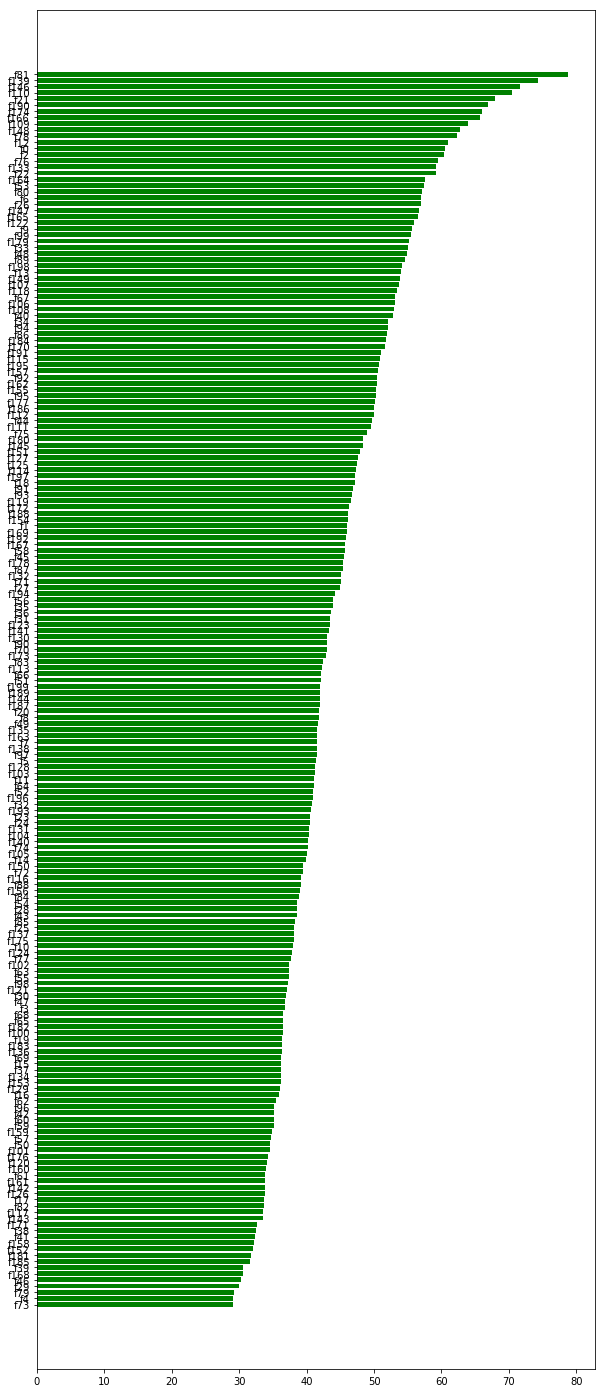

In [60]:
import operator
feature_importance = model_op_1.get_score(importance_type='gain')
feature_importance = sorted(feature_importance.items(), key=operator.itemgetter(1))
feature_importance = pd.DataFrame(feature_importance)
plt.figure(figsize=(10,25))
plt.barh(feature_importance[0], feature_importance[1], color='g')
plt.show()

The five most important features in this model are shown in the table below

In [64]:
feature_importance.columns = ['Feature', 'Importance']
feature_importance.tail(5)

,Feature,Importance
195,f21,67.939088
196,f110,70.389316
197,f146,71.586454
198,f139,74.283726
199,f81,78.824313


Feature engineering is not taking place in this project.

### Final parameter selection

In [ ]:
'scale_pos_weight': 1/spw, # difference between the positive and negative classes
'max_depth': 1,
'eta': 0.02, #Learning rate
'subsample': 0.25,  #Reduces overfitting, range 0-1, 0.5-0.5 would be 50% training data
'colsample_bytree': 0.03, # range 0-1
'lambda': 0.75, # L2 regularisation term on weights - Ridge
'alpha': 0.15, # L1 regularisation term on weights - Lasso
'min_child_weight': 4.5, # range 0-inf,
'max_delta_step': 1.25, # range 0-inf, useful in highly imbalance class sets
'objective': 'binary:logistic', # model type
'eval_metric': 'auc', # evaulation type
'verbosity': 0, #printing of messages 0 (silent), 1 (warning), 2 (info), 3 (debug)
'silent': True #Depricated use verbosity - although does stop lots of messages

### Generating prediction for submision

The following code will be run on the AWS instance, this will train a model on the entire train dataset and then fit the test dataset generating a submission csv file ready to be submitted to the Kaggle page for evaluation. 

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, QuantileTransformer
import xgboost as xgb
from sklearn.metrics import roc_curve, auc
import gc
from sklearn.model_selection import train_test_split



df = pd.read_csv('train.csv.zip', index_col = 'ID_code')

sc = StandardScaler()
X_scaled = sc.fit_transform(df.drop('target',axis=1))
X_scaled = pd.DataFrame(X_scaled)
X_scaled.columns = df.drop('target',axis=1).columns

qt = QuantileTransformer(output_distribution='normal')
X_quant = qt.fit_transform(X_scaled)
X_quant = qt.transform(X_quant)
X_train, X_test, y_train, y_test = train_test_split(X_quant, df.target, random_state=100, test_size=0.2)

train_data = xgb.DMatrix(data=X_train, label=y_train)
valid_data = xgb.DMatrix(data=X_test, label=y_test)
watchlist = [(train_data, 'train'), (valid_data, 'valid_data')]

spw = float(len(df.target[df.target == 1])) / float(len(df.target[df.target == 0]))

model_params = {
        'scale_pos_weight': 1/spw, # difference between the positive and negative classes
        'max_depth': 1,
        'eta': 0.02, #Learning rate
        'subsample': 0.29,  #Reduces overfitting, range 0-1, 0.5-0.5 would be 50% training data
        'colsample_bytree': 0.04, # range 0-1
        'lambda': 0.57, # L2 regularisation term on weights - Ridge
        'alpha': 0.08, # L1 regularisation term on weights - Lasso
        'min_child_weight': 5.45, # range 0-inf,
        'max_delta_step': 1.25, # range 0-inf, useful in highly imbalance class sets
        'objective': 'binary:logistic', # model type
        'eval_metric': 'auc', # evaulation type
        'verbosity': 0, #printing of messages 0 (silent), 1 (warning), 2 (info), 3 (debug)
        'silent': True #Depricated use verbosity - although does stop lots of messages
    }
tr_model = xgb.train(
    dtrain=train_data,
    num_boost_round=10000,
    evals=watchlist,
    early_stopping_rounds=400,
    verbose_eval=100,
    params=model_params)

y_pred_train = tr_model.predict(xgb.DMatrix(X_train), ntree_limit=tr_model.best_ntree_limit)

df_sub = pd.read_csv('test.csv.zip', index_col = 'ID_code')

sc = StandardScaler()
X_scaled_sub = sc.fit_transform(df_sub)
X_scaled_sub = pd.DataFrame(X_scaled_sub)
X_scaled_sub.columns = df_sub.columns

qt = QuantileTransformer(output_distribution='normal')
X_quant_sub = qt.fit_transform(X_scaled_sub)
X_quant_sub = qt.transform(X_quant_sub)

y_pred_sub = tr_model.predict(xgb.DMatrix(X_quant_sub), ntree_limit=tr_model.best_ntree_limit)


pd.DataFrame(y_pred_sub).to_csv('submission.csv')


# Interpret

The problem evaluated in this project is abstract; there is not a particularly clear link between the dataset a reality. As a result the only substantial interpretation that can be completed is the comparision of the AUC between different models. 

# Further Work
The model may be able to be improved through feature optimisation and also conducting PCA.

### Example code of running a grid search

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import gc
from sklearn.preprocessing import StandardScaler, QuantileTransformer
import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc

df = pd.read_csv('sample.csv', index_col = 'ID_code')

sc = StandardScaler()
X_scaled = sc.fit_transform(df.drop('target',axis=1))
X_scaled = pd.DataFrame(X_scaled)
X_scaled.columns = df.drop('target',axis=1).columns

qt = QuantileTransformer(output_distribution='normal')
X_quant = qt.fit_transform(X_scaled)
X_quant = qt.transform(X_quant)

X_train, X_test, y_train, y_test = train_test_split(X_quant, df.target, random_state=100, test_size=0.2)

def AUC(y_train, y_pred_train, y_test, y_pred_test):
    fpr, tpr, thresholds = roc_curve(y_train, y_pred_train)
    AUC_train = round(auc(fpr, tpr),4)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_test)
    AUC_test = round(auc(fpr, tpr),4)
    return AUC_train, AUC_test

spw = float(len(y_train[y_train == 1])) / float(len(y_train[y_train == 0]))


R = [1/spw, 12.7, 12.8, 12.9] # difference between the positive and negative classes
I = [0.01, 0.02, 0.03] # learning rate
J = [1,2] # max_depth
K = [0.25, 0.29, 0.35] # subsample
L = [0.03, 0.04, 0.05] # colsample_bytree
M = [0.55, 0.57, 0.59] # L2 regularisation term on weights - Ridge
N = [0.06, 0.08, 0.1] # L1 regularisation term on weights - Lasso
P = [4.5, 5.45, 6.5] # range 0-inf,
Q = [1.25, 1.53, 1.75] # range 0-inf, useful in highly imbalance class sets

train_data = xgb.DMatrix(data=X_train, label=y_train)
valid_data = xgb.DMatrix(data=X_test, label=y_test)
watchlist = [(train_data, 'train'), (valid_data, 'valid_data')]
results = []
for i in I:
    for j in J:
        for k in K:
            for l in L:
                for m in M:
                    for n in N:
                        for p in P:
                            for q in Q:
                                for r in R:
                                    model_params = {
                                        'eta': i, #Learning rate
                                        'max_depth': j,
                                        'subsample': k,  #Reduces overfitting, range 0-1, 0.5-0.5 would be 50% training data
                                        'colsample_bytree': l, # range 0-1
                                        'lambda': m, # L2 regularisation term on weights - Ridge
                                        'alpha': n, # L1 regularisation term on weights - Lasso
                                        'min_child_weight': p, # range 0-inf,
                                        'max_delta_step': q, # range 0-inf, useful in highly imbalance class sets
                                        'scale_pos_weight': r, # difference between the positive and negative classes
                                        'objective': 'binary:logistic', # model type
                                        'eval_metric': 'auc', # evaulation type
                                        'verbosity': 0, #printing of messages 0 (silent), 1 (warning), 2 (info), 3 (debug)
                                        'silent': True #Depricated use verbosity - although does stop lots of messages
                                            }
                                    tr_model = xgb.train(
                                        dtrain=train_data,
                                        num_boost_round=100000,
                                        evals=watchlist,
                                        early_stopping_rounds=4000,
                                        verbose_eval=2000,
                                        params=model_params)
                                    y_pred_train = tr_model.predict(xgb.DMatrix(X_train), ntree_limit=tr_model.best_ntree_limit)
                                    y_pred_test = tr_model.predict(xgb.DMatrix(X_test), ntree_limit=tr_model.best_ntree_limit)
                                    auc_train, auc_test = AUC(y_train, y_pred_train, y_test, y_pred_test)
                                    print(' i: '+str(i) + ' j: ' +str(j), ' k: ' +str(k) + ' l:' +str(l), ' m: ' +str(m) + ' n: ' +str(n) +' p: ' +str(p) + ' q: ' +str(q) + ' r: '+str(r) +' AUC Train: ' +str(auc_train)+' AUC Test: ' +str(auc_test))
                                    results.append({'i':i, 'j':j, 'k':k, 'l':l, 'm':m, 'n':n, 'p':p, 'q':q, 'r':r, 'AUC_train':auc_train, 'AUC_test': auc_test})

pd.DataFrame(results).to_csv('search_results.csv')
